# Recommendations

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

CURR_PATH = Path.cwd()
SEED = 59

warnings.filterwarnings('ignore')
font_family = "Calibri"

data_path = CURR_PATH.parents[0] / 'data'

In [2]:
styles = [
    dict(selector="th", props=[("font-size", "11pt"),
                               ("text-align", "center"),
                               ('font-family', font_family),
                               ('background-color', 'white'),
                               ('border-style', 'solid'),
                               ('border-color', 'grey'),
                               ('border-width', 'thin')]),
    dict(selector="td", props=[("font-size", "11pt"),
                               #("text-align", "center"),
                               ('font-family', font_family),
                               #('background-color', 'white'),
                               ('border-style', 'solid'),
                               ('border-color', 'grey'),
                               ('border-width', 'thin')]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

sns.set_theme(context='paper',  # notebook, paper, talk
              style='ticks', 
              font=font_family, 
              font_scale=2,
             )

## Data

In [19]:
recoms = pd.read_csv(data_path / 'recom_data.csv', sep=';')

set_cols = [
    'Passed_Past', 'Passed_Next', 
    'ID_TO', 'D_List', 'Count_Next_TO',
    'Nbrs_Passed_Next_TO', 'AC', 'No_Recom_Rule', 'R', 'C', 'M', 'W', 'NoR',
    'NR'
]

for c in set_cols:
    recoms[c] = recoms[c].replace('set()',
                                  '{}').replace('None',
                                                '{}').apply(literal_eval)

TYPES = recoms['T'].unique()
SEMS = recoms['S'].unique()

print(recoms.shape, TYPES, SEMS)
recoms.sample(n=5, random_state=SEED)

(16392, 64) ['AN' 'AN1' 'AN2' 'AN3' 'AN4' 'GN'] [2 3]


,P,ID,ST,#E_1,#E_2,#E_3,#F_1,#F_2,#F_3,#NE_1,...,ACC,REC_1,REC_0,BACC,PREC_1,F1,MCC,NT,MPT,PS
8464,CM,1974,G,5.0,6.0,6.0,0.0,0.0,0.0,0.0,...,1.000000,1.0,0.0,0.5,1.000000,1.0,0.0,AN,P4,CM2
7264,CM,421,D,5.0,5.0,7.0,1.0,0.0,2.0,0.0,...,1.000000,1.0,0.0,0.5,1.000000,1.0,0.0,AN,P4,CM2
9111,CM,2788,D,5.0,6.0,6.0,0.0,1.0,2.0,0.0,...,0.666667,0.8,0.0,0.4,0.800000,0.8,-0.2,AN,P3,CM2
1898,AR,1937,G,5.0,6.0,6.0,0.0,0.0,0.0,0.0,...,0.666667,1.0,0.0,0.5,0.666667,0.8,0.0,AN,P2,AR2
1373,AR,1477,G,5.0,6.0,6.0,0.0,0.0,1.0,0.0,...,1.000000,1.0,0.0,0.5,1.000000,1.0,0.0,GN,P0,AR2


## Courses' Intersections F1 and Recall

In [4]:
ct_f1 = pd.crosstab([recoms['ST'], recoms['PS']], recoms['T'],
            values=recoms['F1'], aggfunc='mean', margins=True)

ct_f1 = pd.concat([ct_f1], keys=['F1'], names='', axis=1)

ct_rec = pd.crosstab([recoms['ST'], recoms['PS']], recoms['T'],
            values=recoms['REC_1'], aggfunc='mean', margins=True)

ct_rec = pd.concat([ct_rec], keys=['Recall'], names='', axis=1)

pd.concat([ct_f1, ct_rec], axis=1).style.format('{:.4f}')\
    .set_table_styles(styles)\
    .background_gradient(cmap='PRGn', axis=None, vmin=0, vmax=1)

## Number of Recommended Courses

### Crosstab

In [5]:
def quantile_25(growth_vals:pd.Series):
    return growth_vals.quantile(.25)

def quantile_75(growth_vals:pd.Series):
    return growth_vals.quantile(.75)

In [6]:
#.quantile([0.25, 0.5, 0.75])
ct_median = pd.crosstab([recoms['ST'], recoms['PS']], recoms['T'],
            values=recoms['#R'], aggfunc=[quantile_25, 'median', quantile_75, 'mad'], margins=True)

cols = [(t, sc) for t in TYPES for sc in ['quantile_25', 'median', 'quantile_75','mad']]

ct_median = ct_median.swaplevel(axis=1)[cols]#.sort_index(axis=1)#.drop(columns=['median', 'mad'])

ct_median.columns = pd.MultiIndex.from_tuples([(c[0], c[1].replace('mad', 'Mad')\
                                                    .replace('median', 'Med')\
                                               .replace('quantile_25', 'Q25')\
                                               .replace('quantile_75', 'Q75')) 
                                               for c in ct_median.columns], 
                                              names=('T', '')) 

ct_median_style = ct_median.style.format('{:.1f}')\
    .set_table_styles(styles)\
    #.background_gradient(cmap='Blues', axis=None, subset=[c for c in ct_median.columns if c[1]=='Med'])\
    #.background_gradient(cmap='Oranges', axis=None, subset=[c for c in ct_median.columns if c[1]=='Mad'])\

ct_median_style

### Boxplot

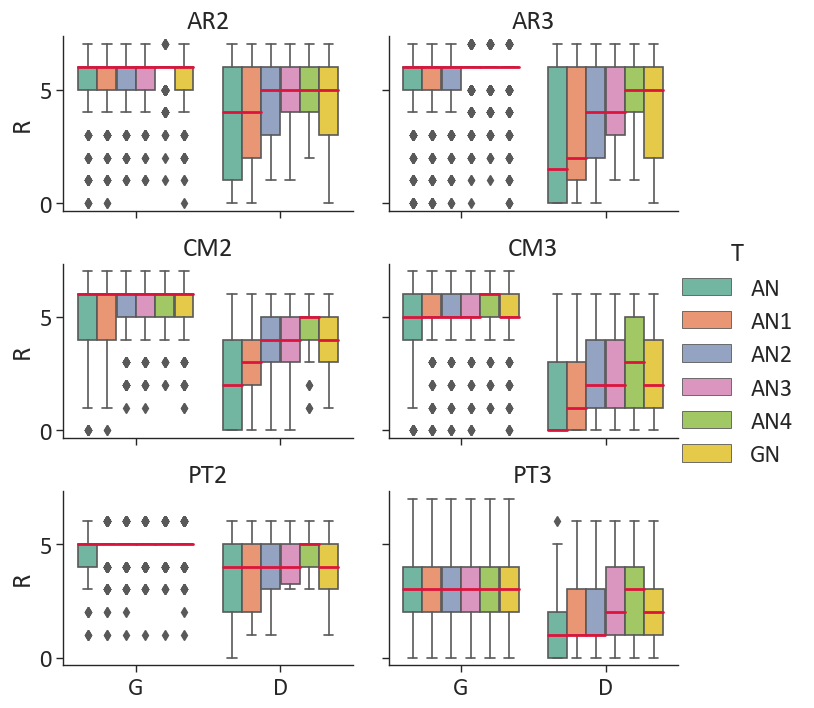

In [7]:
bp = sns.catplot(data=recoms.sort_values(['P', 'S', 'MPT', 'NT']),
                 x='ST',
                 y='#R',
                 kind="box",
                 hue='T',
                 hue_order=TYPES,#['AN', 'AN1', 'AN2', 'AN3', 'AN4', 'GN'],
                 palette='Set2',
                 col='S', row='P',
                 medianprops={"color": "crimson", 'linewidth':2},
                 height=3,
                 aspect=1.2)

bp.fig.subplots_adjust(top=0.8) 
bp.set_titles("{row_name}{col_name}")
bp.set(ylabel ="R", xlabel='')

plt.show()

## Recommended vs Enrolled / Passed

In [8]:
recoms['#R-#E'] = [r-x2 if s==2 else r-x3
                 for s, x2, x3, r in zip(recoms['S'],
                                   recoms['#E_2'], 
                                   recoms['#E_3'], 
                                   recoms['#R'])]
recoms['#R-#P'] = [r-x2 if s==2 else r-x3
                 for s, x2, x3, r in zip(recoms['S'],
                                   recoms['#P_2'], 
                                   recoms['#P_3'], 
                                   recoms['#R'])]

recoms[['ID','S','#R','#E_2','#E_3', '#R-#E', '#P_2','#P_3', '#R-#P']].sample(n=5, random_state=SEED)

,ID,S,#R,#E_2,#E_3,#R-#E,#P_2,#P_3,#R-#P
8464,1974,2,6,6.0,6.0,0.0,6.0,6.0,0.0
7264,421,2,4,5.0,7.0,-1.0,4.0,5.0,0.0
9111,2788,2,5,6.0,6.0,-1.0,5.0,2.0,0.0
1898,1937,2,6,6.0,6.0,0.0,4.0,6.0,2.0
1373,1477,2,6,6.0,6.0,0.0,6.0,5.0,0.0


In [9]:
ct_e = pd.crosstab([recoms['ST'],recoms['PS']], 
                 recoms['T'],
                values=recoms['#R-#E'], aggfunc='median')
ct_e = pd.concat([ct_e], keys=['R-E'], names='', axis=1)

ct_e

R-E                         
T        AN  AN1  AN2  AN3  AN4   GN
ST PS                               
D  AR2 -2.0 -1.0 -1.0 -1.0  0.0 -1.0
   AR3 -3.0 -2.0 -1.0 -1.0  0.0 -1.0
   CM2 -3.0 -2.0 -1.0 -1.0 -1.0 -1.0
   CM3 -4.0 -3.0 -2.0 -2.0 -1.0 -2.0
   PT2 -2.0 -2.0 -1.0 -1.0 -1.0 -1.0
   PT3 -5.0 -4.0 -4.0 -4.0 -3.0 -4.0
G  AR2  0.0  0.0  0.0  0.0  0.0  0.0
   AR3  0.0  0.0  0.0  0.0  0.0  0.0
   CM2  0.0  0.0  0.0  0.0  0.0  0.0
   CM3 -1.0  0.0  0.0  0.0  0.0  0.0
   PT2  0.0  0.0  0.0  0.0  0.0  0.0
   PT3 -4.0 -4.0 -4.0 -3.0 -3.0 -3.0

In [10]:
ct_p = pd.crosstab([recoms['ST'],recoms['PS']], 
                 recoms['T'],
                values=recoms['#R-#P'], aggfunc='median')
ct_p = pd.concat([ct_p], keys=['R-P'], names='', axis=1)

ct_p

R-P                         
T        AN  AN1  AN2  AN3  AN4   GN
ST PS                               
D  AR2  0.5  1.0  1.0  2.0  2.0  1.0
   AR3  0.0  1.0  2.0  3.0  3.0  2.0
   CM2  0.0  1.0  2.0  2.0  3.0  2.0
   CM3  0.0  0.0  1.0  1.0  2.0  1.0
   PT2  1.0  1.0  1.0  2.0  2.0  1.0
   PT3 -0.5  0.0  0.0  0.0  0.0  0.0
G  AR2  0.0  0.0  0.0  0.0  0.0  0.0
   AR3  0.0  0.0  0.0  0.0  0.0  0.0
   CM2  0.0  0.0  0.0  0.0  0.0  0.0
   CM3  0.0  0.0  0.0  0.0  0.0  0.0
   PT2  0.0  0.0  0.0  0.0  0.0  0.0
   PT3 -3.0 -3.0 -3.0 -3.0 -3.0 -3.0

In [11]:
ct = pd.concat([ct_e, ct_p], axis=1)

ct_styled = ct.style.format('{:.1f}')\
    .set_table_styles(styles)\
    .apply(lambda x: ["background:goldenrod" if v ==0 else "" for v in x], axis = 1)
ct_styled

## Neighbors' Distance & Number of Empty Recom Sets

In [12]:
r_d = recoms.groupby(['P', 'S', 'PS', 'ST', 'T','#R'])\
        .agg(Count=('ID', 'nunique'),
             Mean_D=('D_Mean', 'mean'),
             Mean_F1=('F1', 'mean'))\
        .reset_index().rename(columns={'#R': 'N_R'})\

r_d.head()

,P,S,PS,ST,T,N_R,Count,Mean_D,Mean_F1
0,AR,2,AR2,D,AN,0,11,1.599584,0.000000
1,AR,2,AR2,D,AN,1,27,1.411904,0.313580
2,AR,2,AR2,D,AN,2,18,1.799750,0.249471
3,AR,2,AR2,D,AN,3,10,1.940688,0.397619
4,AR,2,AR2,D,AN,4,14,1.690393,0.444558


### Scatter-Plot + Histogram

In [13]:
# excerpt - only one program!

p = 'CM'

data_ = r_d[(r_d['P']==p)]

# get the sum of the two status for barplot
data_agg_ = data_[data_['P']==p]\
    .groupby(['P', 'S', 'PS', 'T',  'N_R'])\
    .agg(Count=('Count', 'sum'))\
    .reset_index().pivot(index=['P', 'S', 'PS', 'T'], 
                           columns='N_R')\
    .fillna(0).stack().reset_index()


# for some N_R there are no students - handle that for correct plot
data_ = data_.pivot_table(index=['P', 'S', 'PS', 'T', 'ST'], 
                          columns='N_R', values='Mean_D')\
    .fillna(-1).stack().reset_index().rename(columns={0: 'Mean_D'})

data_['Mean_D'] = [val if val != -1 else np.nan
                  for val in data_['Mean_D']]

data_[(data_['S']==2) & (data_['T']=='AN4')].head()

,P,S,PS,T,ST,N_R,Mean_D
64,CM,2,CM2,AN4,D,0,NaN
65,CM,2,CM2,AN4,D,1,6.260280
66,CM,2,CM2,AN4,D,2,4.963160
67,CM,2,CM2,AN4,D,3,3.289361
68,CM,2,CM2,AN4,D,4,2.547641


In [15]:

# check the y limits
print(round(data_agg_[data_agg_['T'].isin((TYPES))]['Count'].max(),0))
max_count = round(data_agg_[data_agg_['T'].isin((TYPES))]['Count'].max()*1.1,0)
max_dist = round(data_[data_['T'].isin((TYPES))]['Mean_D'].max()*1.1,0)

print(max_count, max_dist)
# 420
# 17

227.0
250.0 12.0


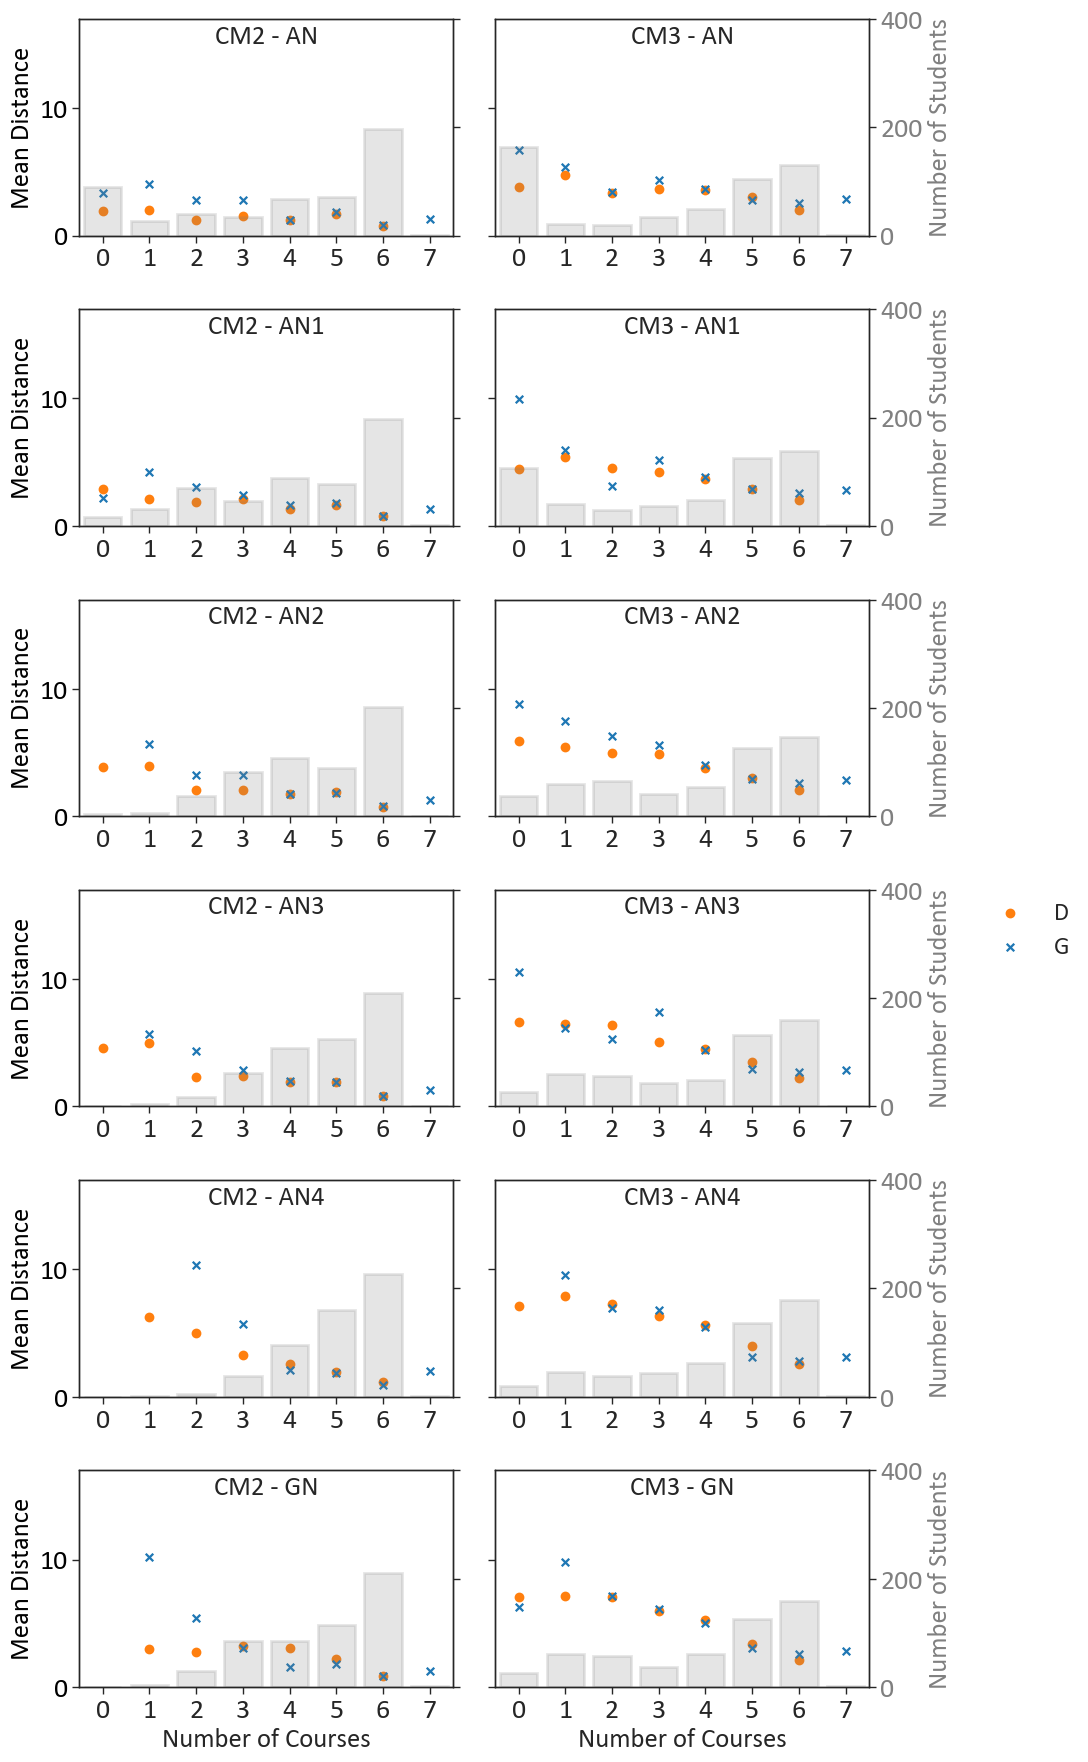

In [22]:
fig = plt.figure(figsize=(10,18)) # breite, höhe

n = 1


for t in TYPES:
    for s in SEMS:
        #print(t,s)
        data = r_d[(r_d['P']==p) & (r_d['S']==s) & (r_d['T']==t)]

        # plot 1
        ax = fig.add_subplot(len(TYPES), len(SEMS), n)

        stud_color = 'grey'
        dist_color = 'black'

        g = sns.pointplot(data=data_[(data_['S']==s) & (data_['T']==t)],
                          x='N_R',
                          y='Mean_D',
                          hue='ST',
                          markers=['o', 'x'],
                          join=False,
                          palette=['tab:orange', 'tab:blue'],
                          ax=ax)

        plt.legend([], [], frameon=False)

        #ax.set_title(f'S={s} | P={p} | T={t}')
        ax.set_title(f'{p}{s} - {t}', x=0.5, y=0.85)
        ax.set_ylim([0, 17]) #max_dist
        ax.tick_params(axis='y', labelcolor=dist_color)

        ax.yaxis.set_tick_params(labelsize = 20)

        # plot 2
        ax2 = ax.twinx()
        b = sns.barplot(data=data_agg_[(data_agg_['S']==s) & (data_agg_['T']==t)],
                        x="N_R",
                        y='Count',
                        color=stud_color,
                        #facecolor='white',#(0, 0, 0, 0),
                        edgecolor=stud_color,
                        linewidth=2,
                        alpha=0.2,
                        errorbar=None,
                        ax=ax2)
        
        plt.legend([], [], frameon=False)
        


        #plt.setp(ax2.collections, sizes=[100])
        ax2.set(ylim=(0, 400)) #
        ax2.tick_params(axis='y', labelcolor=stud_color)
        ax2.yaxis.set_tick_params(labelsize = 20)



        # left y axis
        if n in np.arange(1,len(SEMS)*len(TYPES), len(SEMS)):#(n == 1) | (n == 5):
            ax.set_ylabel('Mean Distance', color=dist_color)
        else:
            ax.set_ylabel(None)
            ax.set(yticklabels=[])

        # right y axis
        if n in np.arange(len(SEMS),len(SEMS)*len(TYPES)+1, len(SEMS)):
            ax2.set_ylabel('Number of Students', color=stud_color)

        else:
            ax2.set_ylabel(None)
            ax2.set(yticklabels=[])

        if (n <= len(SEMS)*len(TYPES)-len(SEMS)):
            ax.set_xlabel(None)
        else:
            ax.set_xlabel('Number of Courses')

        ax.xaxis.set_tick_params(labelsize = 20)


        n += 1
        
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles,
           labels,
           ncol=1,frameon=False,
                 #loc='center right'
           bbox_to_anchor=(1.11, 0.5)
                 #bbox_to_anchor=(0.5, 0.05)
                )

plt.tight_layout()

plt.show()

### Tables

In [23]:
pt_d = pd.pivot_table(data = r_d[r_d['ST']=='D'], index=['PS', 'T'], columns='N_R',
        values=['Count', 'Mean_D'])#.fillna('')
pt_d_styled = pt_d.style\
    .format('{:.1f}', subset=[c for c in pt_d.columns if c[0] != 'Count'])\
    .format('{:.0f}', subset=[c for c in pt_d.columns if c[0] == 'Count'])\
    .set_table_styles(styles)\
    .background_gradient(cmap='Blues', axis=None, subset=[c for c in pt_d.columns if c[0]=='Count'])\
    .background_gradient(cmap='Oranges', axis=None, subset=[c for c in pt_d.columns if c[0]=='Mean_D'])\
    .background_gradient(cmap='Greens', axis=None, subset=[c for c in pt_d.columns if c[0]=='Mean_F1'])\
    .applymap(lambda x: '' if x == x else 'background-color: lightgrey')
pt_d_styled

In [24]:
pt_g = pd.pivot_table(data = r_d[r_d['ST']=='G'], index=['PS', 'T'], columns='N_R',
        values=['Count', 'Mean_D'])#.fillna('')
pt_g_styled = pt_g.style\
    .format('{:.1f}', subset=[c for c in pt_g.columns if c[0] != 'Count'])\
    .format('{:.0f}', subset=[c for c in pt_g.columns if c[0] == 'Count'])\
    .set_table_styles(styles)\
    .background_gradient(cmap='Blues', axis=None, subset=[c for c in pt_g.columns if c[0]=='Count'])\
    .background_gradient(cmap='Oranges', axis=None, subset=[c for c in pt_g.columns if c[0]=='Mean_D'])\
    .background_gradient(cmap='Greens', axis=None, subset=[c for c in pt_g.columns if c[0]=='Mean_F1'])\
    .applymap(lambda x: '' if x == x else 'background-color: lightgrey')
pt_g_styled